In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [75]:
df = pd.read_csv('homeprices_banglore.csv')
df.sample(5)

,area,bedrooms,price
10,1800,3,82.0
14,2250,3,101.0
18,2770,3,102.0
9,3700,5,167.0
17,1540,3,60.0


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   area      20 non-null     int64  
 1   bedrooms  20 non-null     int64  
 2   price     20 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 608.0 bytes


In [77]:
x = df.drop('price', axis = 'columns')
y = df[['price']]

In [78]:
from sklearn.preprocessing import MinMaxScaler

scaleX = MinMaxScaler()
scaleY = MinMaxScaler()

scaled_x = scaleX.fit_transform(x)
scaled_y = scaleY.fit_transform(y)

In [79]:
scaled_x.shape, scaled_y.shape

((20, 2), (20, 1))

#### We will use very simple home prices data set to implement mini batch gradient descent in python. 

1. Batch gradient descent uses *all* training samples in forward pass to calculate cumulitive error and than we adjust weights using derivaties

2. Stochastic GD: we randomly pick *one* training sample, perform forward pass, compute the error and immidiately adjust weights

3. Mini batch GD: we use a batch of m samples where 0 < m < n (where n is total number of training samples)

In [80]:
def batch_gradient_descent(x,y, epoch, learning_rate):
    n_features = x.shape[1]
    n_sample   = x.shape[0]
    weight     = np.ones(shape = (n_features))
    bias       = 0
    
    Cost  = []
    Epoch = []
    
    for i in range(epoch):
        y_pred = np.dot(weight, x.T) + bias
        
        w_Grad = -(2/n_sample) * (x.T.dot(y-y_pred))
        b_Grad = -(2/n_sample) * np.sum(y-y_pred)

        weight = weight - learning_rate * w_Grad
        bias   = bias   - learning_rate * b_Grad
        
        
        cost = np.mean(np.square(y - y_pred))
        Cost.append(cost)
        Epoch.append(i)
        
        if min(Cost) < cost:
            break
        
    return weight, bias,  Cost, Epoch

In [81]:
scaled_y.reshape(scaled_y.shape[0],).shape

(20,)

In [82]:
w, b, costs, Epochs = batch_gradient_descent(scaled_x, scaled_y.reshape(scaled_y.shape[0],), 500, 0.01)
w,b

(array([0.70712464, 0.67456527]), -0.23034857438407427)

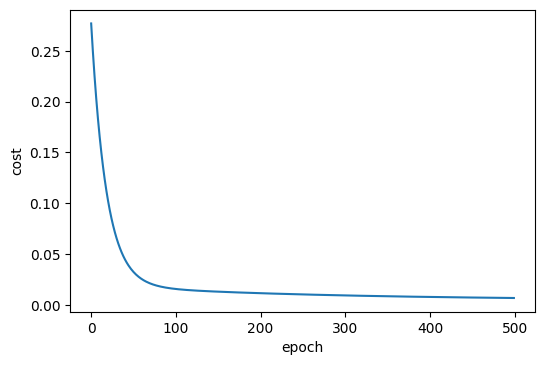

In [83]:
plt.figure(dpi = 100)
plt.plot(Epochs, costs)
plt.xlabel('epoch')
plt.ylabel('cost')
plt.show()

### Prediction

In [84]:
def predict(area, bedroom, w,b):
    x_scale = scaleX.transform([[area, bedroom]])[0]
    
    scaled_price = w[0]*x_scale[0] + w[1] * x_scale[1] + b
    
    return scaleY.inverse_transform([[scaled_price]])[0][0]

In [85]:
predict(2600, 4, w,b)

128.45484403267596

In [86]:
predict(1111, 2, w,b)

33.906978176894874

In [87]:
def stochastic_gradient_descent(x, y, epoch, learning_rate):
    n_features = x.shape[1]
    n_sample   = x.shape[0]
    weight     = np.ones(shape = (n_features))
    bias       = 0
    
    Cost  = []
    Epoch = []
    
    for i in range(epoch):
        random_index = np.random.randint(0,n_sample-1)
        sample_x     = x[random_index]
        sample_y     = y[random_index]
        y_pred       = np.dot(weight, sample_x.T) + bias
        
        w_Grad = -(2/n_sample) * (sample_x.T.dot(sample_y-y_pred))
        b_Grad = -(2/n_sample) * np.sum(sample_y - y_pred)

        weight = weight - learning_rate * w_Grad
        bias   = bias   - learning_rate * b_Grad
        
        
        cost = np.square(sample_y - y_pred)
        if i%1000 ==0:
            Cost.append(cost)
            Epoch.append(i)

        #if min(Cost) < cost:
            #break      
        
    return weight, bias, cost, Cost, Epoch

In [88]:
w_sgd, b_sgd, c_sgd, costs_sgd, Epochs_sgd = stochastic_gradient_descent(scaled_x, 
                                                scaled_y.reshape(scaled_y.shape[0],),
                                                100000, 
                                                0.001)
w_sgd, b_sgd, c_sgd

(array([0.72170383, 0.70594756]), -0.2611675457645351, 0.00019233679172002597)

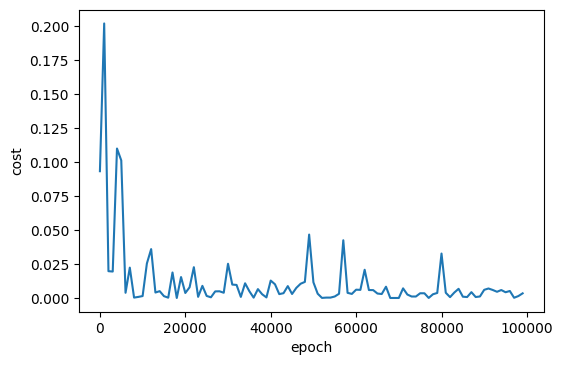

In [89]:
plt.figure(dpi = 100)
plt.plot(Epochs_sgd, costs_sgd)
plt.xlabel('epoch')
plt.ylabel('cost')
plt.show()

In [90]:
predict(2600, 4, w_sgd,b_sgd)

128.69337525528866

In [91]:
predict(1000, 2, w_sgd,b_sgd)

27.287422987532143

In [92]:
def mini_batch_gradient_descent(x, y, epochs = 100, batch_size = 5, learning_rate = 0.01):
    
    n_features = x.shape[1]
    n_samples = x.shape[0]   # number of rows in X

    # numpy array with 1 row and columns equal to number of features. 
    # In our case number_of_features = 3 (area, bedroom and age)
    w = np.ones(shape=(n_features)) 
    b = 0
    
    if batch_size > n_samples: # In this case mini batch becomes same as batch gradient descent
        batch_size = n_samples
        
    Cost = []
    Epoch = []
    
    num_batches = int(n_samples/batch_size)
    
    for i in range(epochs):    
        random_indices = np.random.permutation(n_samples)
        X_tmp = x[random_indices]
        y_tmp = y[random_indices]
        
        for j in range(0,n_samples, batch_size):
            Xj = X_tmp[j:j+batch_size]
            yj = y_tmp[j:j+batch_size]
            y_predicted = np.dot(w, Xj.T) + b
            
            w_grad = -(2/len(Xj))*(Xj.T.dot(yj-y_predicted))
            b_grad = -(2/len(Xj))*np.sum(yj-y_predicted)
            
            w = w - learning_rate * w_grad
            b = b - learning_rate * b_grad
                
            cost = np.mean(np.square(yj-y_predicted)) # MSE (Mean Squared Error)
        
        if i%10==0:
            Cost.append(cost)
            Epoch.append(i)
        
    return w, b, Cost, Epoch

In [93]:
w, b, cost_mgd, epoch_mgd = mini_batch_gradient_descent(scaled_x, scaled_y.reshape(scaled_y.shape[0],), 
                                                    epochs = 100, batch_size = 5)
w, b

(array([0.72462089, 0.69447651]), -0.24759095794515784)

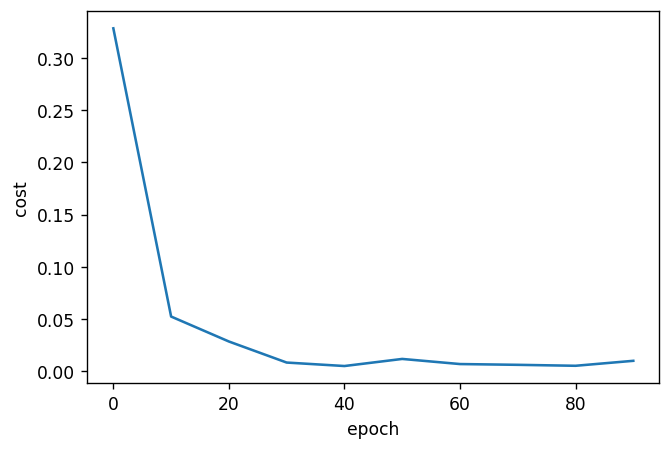

In [94]:
plt.figure(dpi = 123)
plt.xlabel("epoch")
plt.ylabel("cost")
plt.plot(epoch_mgd,cost_mgd)
plt.show()